# 18. 문자를 읽을 수 있는 딥러닝

## 9. 프로젝트 : 다양한 OCR모델 비교하기
우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을것도 같다. 그런데 과연 어떤 것을 사용하는 것이 좋을까?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일이다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠다. 당신이 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정한다.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Step1. 검증용 데이터셋 준비
---
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었다. 우리는 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 한다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요하다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천한다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 하자.

In [2]:
import os
from glob import glob

work_dir = os.getenv('HOME')+'/AIFFEL/Exploration/E18_OCR/image'
img_file_path = work_dir + '/*'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

img_file_path = glob(img_file_path)
img_file_path

['/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection7.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection12.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection2.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection10.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection6.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection11.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection8.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection4.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection14.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection1.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection5.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection9.jpg',
 '/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection13.jpg']

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
---
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보았을 것이다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아보자.

#### Google OCR API

In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [4]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/AIFFEL/Exploration/E18_OCR/ocr_python/my_google_api_key.json'

for img_path in img_file_path:
    # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
    print(" -----------------------------------\n\n" + img_path)
    try:
        detect_text(img_path)
    except UnboundLocalError: 
        print ('Error: UnboundLocalError ' )
        print ("이미지경로:"+  img_path )
        print ('에러발생이유 이미지에서 문자를 찾기 못함')
        print ('---------------------------------------------')

total 7660
-rw-rw-r-- 1 aiffel-dj10 aiffel-dj10 7008164  3월 15 21:57 detection15.jpg
-rw-rw-r-- 1 aiffel-dj10 aiffel-dj10  782152  3월 19 01:35 detection3.jpg
-rw-r--r-- 1 aiffel-dj10 aiffel-dj10   43550  3월 23 01:09 E18_OCR.ipynb
drwxr-xr-x 2 aiffel-dj10 aiffel-dj10    4096  3월 23 01:10 image
drwxr-xr-x 2 aiffel-dj10 aiffel-dj10    4096  3월 16 16:01 ocr_python
 -----------------------------------

/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection7.jpg
Texts:

"The
Geesecal
Coanke Factory
RESTAURANT
, BAKERY , BAR
"

"The"

"Geesecal"

"Coanke"

"Factory"

"RESTAURANT"

","

"BAKERY"

","

"BAR"
bounds: (2550,794),(2929,655),(2981,796),(2602,936)
 -----------------------------------

/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection12.jpg
Texts:

"Speak of the devil
Every cloud has a silver lining.
Walls have ears.
It is a pie in the sky.
A big fish in a little pond.
"

"Speak"

"of"

"the"

"devil"

"Every"

"cloud"

"has"

"a"

"silver"

"lining."

"Walls"

"have

#### Tesseract

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [6]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [7]:
folder_crop_list = []
# dir_path = os.getenv('HOME')+'/aiffel/ocr_python/ocr_img'
print('이미지 개수              ',len(img_file_path))

for i in range(1,len(img_file_path)+1): # 이미지 개수만큼 반복
    #print(i)
    strr = work_dir + "/crop" + str(i)+'/' # 폴더 이름 설정
    folder_crop_list.append(strr) # 폴더 경로 저장
    createFolder(strr) # 폴더 생성
    #print(strr)

print('crop작업에 필요한 폴더 개수',len(folder_crop_list))

이미지 개수               13
crop작업에 필요한 폴더 개수 13


In [8]:
total_cropped_image_path_list =[]

for i in range(1,len(img_file_path)): # 이미지 개수만큼 반복
    cropped_image_path_list = crop_word_regions(img_file_path[i], folder_crop_list[i])
    total_cropped_image_path_list.append(cropped_image_path_list)

/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0000.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0001.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0002.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0003.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0004.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0005.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0006.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0007.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0008.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0009.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0010.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0011.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0012.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0013.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop2/0014.png
/home/aiff

/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0000.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0001.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0002.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0003.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0004.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0005.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0006.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0007.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0008.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0009.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0010.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0011.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0012.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0013.png
/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop10/0014

/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/crop13/0038.png


In [9]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

> TF


“Tn

Penn's

Fair

City

calm

and

grave

Hangs

the

ald

Bell

which

rings

V1LO

WLOTEe

ae

For

Freedom

sleeps

OTL

Freedoms

Shore.”

ie

Caroline

\VW/eston

me U

Denis,

J]

The

Liberty Bell,

1649

VE

TC

f


| »_ 4 ~~ sake i > J j ',

aN

Done


In [10]:
i=1
for tmp in total_cropped_image_path_list: # 이미지 개수만큼 반복
    print("--------",i,"번 이미지-----------------------")
    recognize_images(tmp)
    i= i+1
    print("--------------------------------------------")

-------- 1 번 이미지-----------------------
Spea

kK of

Te

evil

Every

cloua

na

S

2 sSiive

r lining.

Walis

nave

ears.

\

IT

IC


pie

Te

me

SKY. \y

A

OIG

TISN

In

=

ime

pond.

Done
--------------------------------------------
-------- 2 번 이미지-----------------------

_ Tt

T aa | al TU UPERAIEC

Geotourism

Destination

a — ———

Done
--------------------------------------------
-------- 3 번 이미지-----------------------
= 3 bs

Done
--------------------------------------------
-------- 4 번 이미지-----------------------
ge

WHARTUN


The vistenaries

The trendspotters

The early adopters

The achievers


The inflwencers


Be


. _ | (

ao lt

S

| boos a

vias W

tine +i...


Done
--------------------------------------------
-------- 5 번 이미지-----------------------
?

Esser

T | ae

) ORY

F


KNOW


ian ae |

I |

¢


Re &


Stage &


ALT BINGE ¢.

wil.

a

Done
--------------------------------------------

#### keras-ocr

In [11]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj10/.keras-ocr/craft_mlt_25k.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Looking for /home/aiffel-dj10/.keras-ocr/crnn_kurapan.h5


In [12]:
images = [ keras_ocr.tools.read(img_path) for img_path in img_file_path]

In [13]:
prediction_groups = [pipeline.recognize([image_path]) for image_path in img_file_path]

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


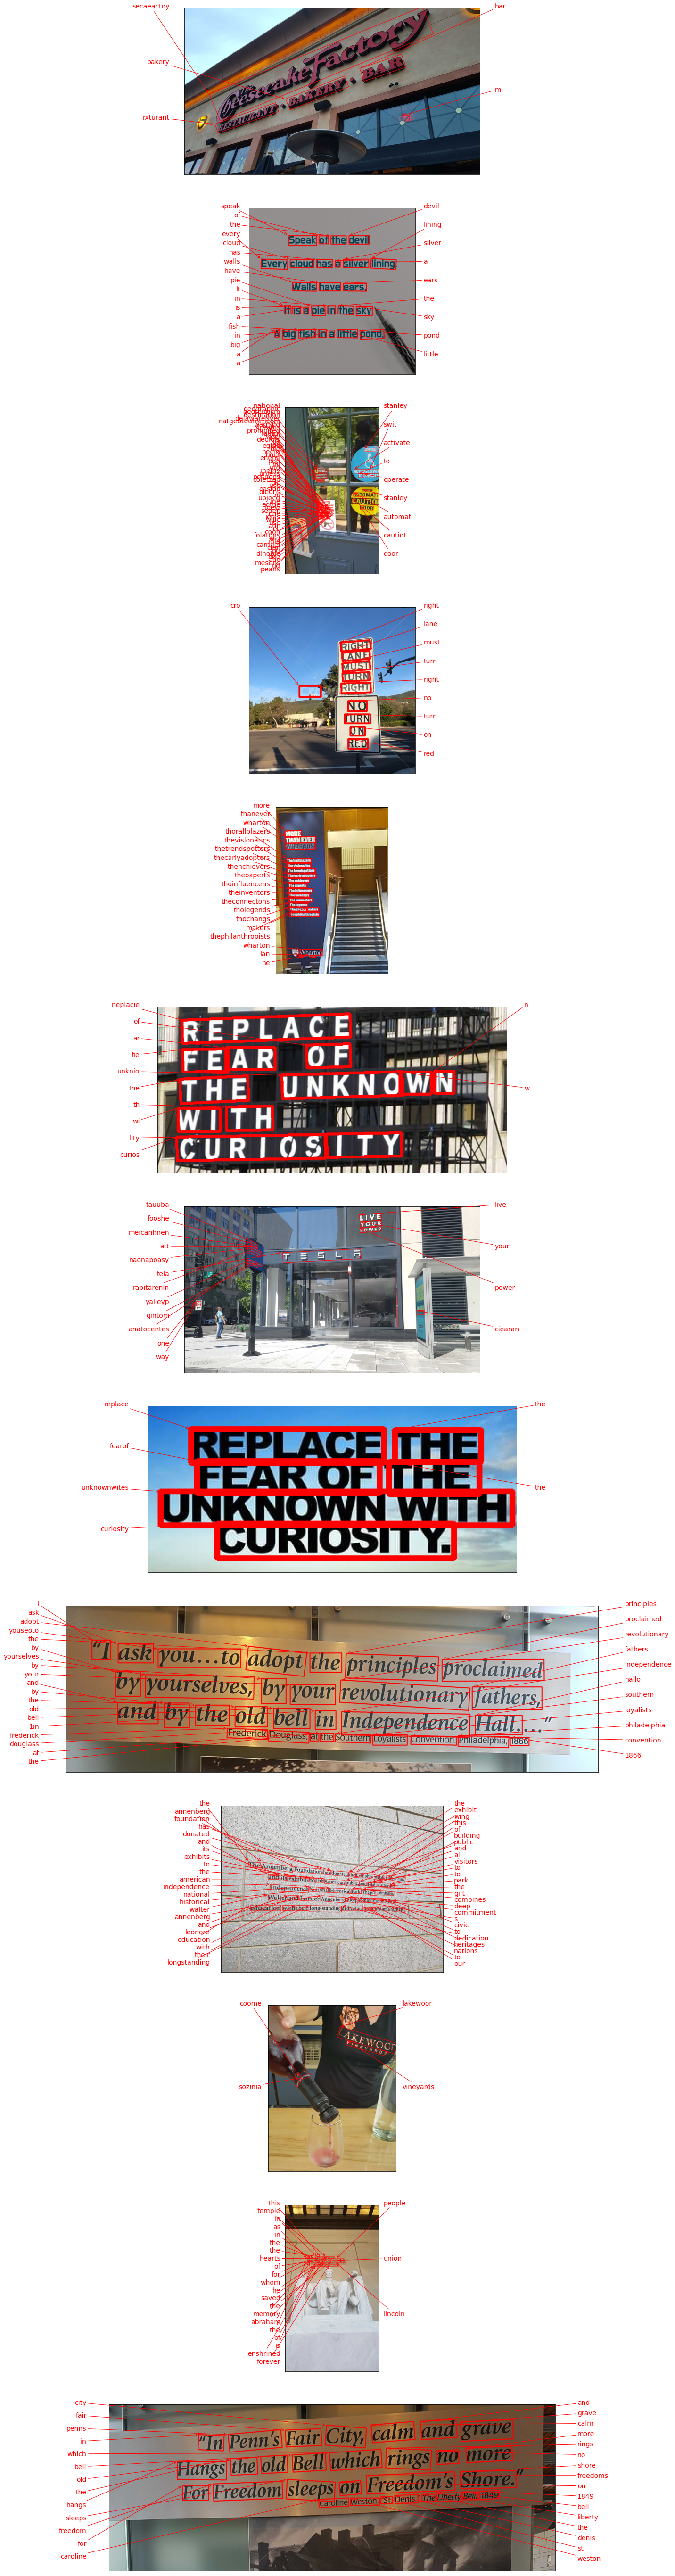

In [14]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Step3. 테스트 결과 정리
---
모듈들마다 출력 형태가 다르다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것이다. 시각화 방법이 함께 활용된다면 더욱 좋겠다.

#### Google OCR API

/home/aiffel-dj10/AIFFEL/Exploration/E18_OCR/image/detection9.jpg<br>
Texts:<br>
<br><br>
"OYO OO<br>
IN THIS TEMPLE<br>
AS IN THE HEARTS OF THE PEOPLE<br>
FOR WH OM HE SAVED THE UNION<br>
THE MEMORY OF ABRAHAM LINCOLN<br>
IS ENSHRINED FOREVER<br>
"

"OYO"

"OO"

"IN"

"THIS"

"TEMPLE"

"AS"

"IN"

"THE"

"HEARTS"

"OF"

"THE"

"PEOPLE"

"FOR"

"WH"

"OM"

"HE"

"SAVED"

"THE"

"UNION"

"THE"

"MEMORY"

"OF"

"ABRAHAM"

"LINCOLN"

"IS"

"ENSHRINED"

"FOREVER"<br>
bounds: (1076,1456),(1303,1455),(1303,1483),(1076,1484)

#### Tesseract

-------- 11 번 이미지-----------------------


seen rma


| : \

ee

TN

THIS

TEMPLE

AS

IN

THE

HEARIS

C)-

THE

PEOPLE

)

FOR

WHOM

re

SAVET)

THE

LINLILON

1S

ENSHRINED

FOREVER

;

THE

MEMORY

( )F

ABRAHAM

Pe Ge) igN

\

,

/

Done

단어를 정확하게 뽑지 못한 모습이다.

In [19]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

dir_crop_path = os.getenv('HOME')+'/AIFFEL/Exploration/E18_OCR/image/crop12/*'
path = glob(dir_crop_path)
img_crop_list = []

for img in path:
    n = cv2.imread(img)
    img_crop_list.append(n)

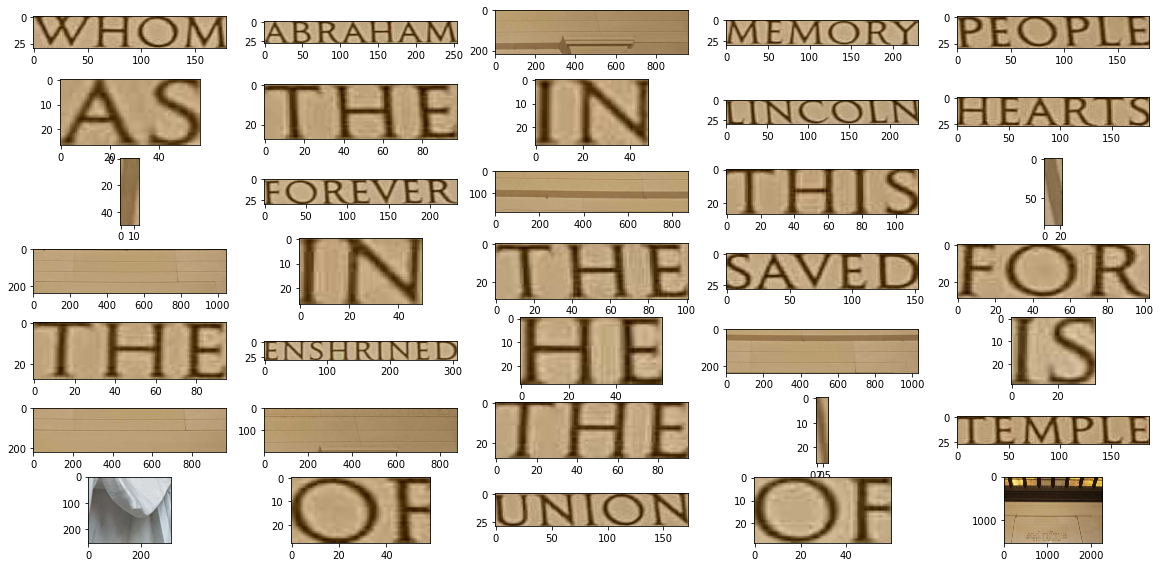

In [22]:
plt.figure(figsize=(20,10))
for i in range(len(img_crop_list)):
    plt.subplot(7,5,i+1)
    img = cv2.cvtColor(img_crop_list[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img)

#### keras-ocr

<img src="./keras_ocr.png" />

### Step4. 결과 분석과 결론 제시
---
* 우선 구현하고자 하는 서비스의 목적과 내용을 먼저 정리한다.
* 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시한다.
* 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정한다.

1. 서비스의 목적과 내용
    - 재무제표 요약 프로그램
        - 재무제표를 한장 정도로 요약하는 프로그램이다. 기업 지표를 계산해주는 기능도 추가될 것이다. OCR을 사용하면, 요약까지는 못하겠지만 detection과 recognition까지는 가능할 것 같다. 
2. OCR 모델들
    - Google OCR API
        * 위에 있는 시각화를 보면, 어느정도 단어 추출의 정확도가 있다는 것을 확인할 수 있다.
    - Tesseract
        * 테서렉트는 단어를 추출해서 이미지를 자르는 부분이 부족하다 보니, 다음 단계인 단어 recognition이 잘 안되는 모습이다. 
    - keras-ocr
        * 제일 좋은 모델이었다. detection이 굉장히 잘되었고, 단어도 잘 보여주었다.(단점, 한글이 안됨.)
        
        
개인적으로 만들고 싶은 프로젝트는 재무제표 요약 모델을 만들고 싶다. 서비스를 위해서는 한글이 지원되면서, detection 성능과, recognition 성능이 좋은 Google OCR API를 사용할 것 같다.

평가기준에 대한 것은 잘 나오지 않아서, 추가로 찾아보았다. 이번 프로젝트에서는 얼마나 단어를 잘 detection하고, recognition하였는지 눈으로 확인했다.

* 추가적인 OCR 평가지표는 [여기](https://sites.google.com/site/textdigitisation/qualitymeasures/basics) 참조

__참고__(수희님 정리)

* Google OCR API : detection O, recognition O
* keras-orc : detection O, recognition △ (한글이 안됨)
* 테서랙트 : detection △, recognition △ (lang='eng+kor' 설정을 통하여 한글/영어를 동시에 찾을 수는 있으나, detection과 recognition 모두 불안정)

### 루브릭
---
* OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?<br>
(_목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다._)

    * __재무제표 요약 서비스가 OCR을 적용하면, 불필요한 정보들은 걸러지고, 기업 분석에 필요한 계산도 가능할 것 같다.__

* 모델 평가기준이 명확하고 체계적으로 세워졌는가?<br>
( _평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다._)
    
    * __이번 노드에서는 평가기준이 나오지 않아서, 눈으로 잘 나왔는지 확인했다. 재무제표 서비스에 맞는 모델은 Google OCR API로 정하였다. 그 이유는 detection과 recognition이 잘되고, 한글도 지원하기 때문이다. 다른 모델들도 찾아보고 싶다.__

* 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?<br>
(_최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다._)
    
    * __15장의 이미지로 테스트를 진행했다.__